# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## Resources: 

* Book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/ 
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf 

## 0. Get setup

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary


# Try to import the going_modular directory, download it from GitHub if it doesn't work
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data with code from: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent",
)

data_20_percent_path


[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency) 
    * Latency = time for prediction to take place 

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)




## 3. Creating an EffNetB2 feature extractor

Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights 

In [6]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = (
    torchvision.models.EfficientNet_B2_Weights.DEFAULT
)  # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(
    weights=effnetb2_weights
)  # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
    param.requires_grad = False


In [7]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(
    effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


c:\Projects\pytorch-course\venv\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), nn.Linear(in_features=1408, out_features=3, bias=True)
)


In [10]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(
    effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [11]:
def create_effnetb2_model(
    num_classes: int = 3, seed: int = 42  # default output classes = 3 (pizza, steak, sushi)
):
    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms


In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)


In [13]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(
    effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [14]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=effnetb2_transforms, batch_size=32
)


In [15]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names


(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [16]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9824 | train_acc: 0.5729 | test_loss: 0.7378 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7097 | train_acc: 0.8479 | test_loss: 0.5876 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5858 | train_acc: 0.8958 | test_loss: 0.4865 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4483 | train_acc: 0.9021 | test_loss: 0.4337 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4233 | train_acc: 0.9146 | test_loss: 0.3893 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4420 | train_acc: 0.8875 | test_loss: 0.3511 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4307 | train_acc: 0.8646 | test_loss: 0.3250 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3809 | train_acc: 0.9062 | test_loss: 0.3461 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3766 | train_acc: 0.8854 | test_loss: 0.3122 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3707 | train_acc: 0.8625 | test_loss: 0.2794 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 loss curves

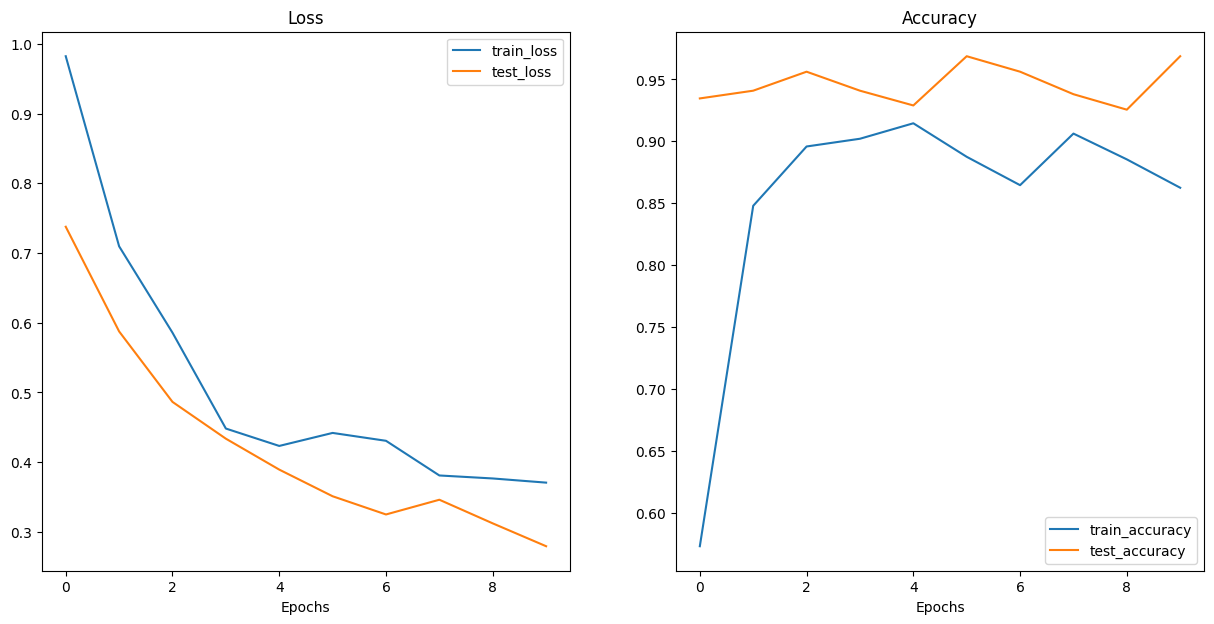

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)


See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 3.5 Saving EffNetB2 feature extractor

In [18]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(
    model=effnetb2,
    target_dir="models",
    model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
)


[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor
Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [19]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
).stat().st_size / (1024 * 1024)
print(
    f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB"
)


Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [20]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params


7705221

In [21]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "number_of_parameters": effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size,
}

effnetb2_stats


{'test_loss': 0.27941632866859434,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset

In [22]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads


Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [23]:
def create_vit_model(num_classes: int = 3, seed: int = 42):
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all of the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

    return model, transforms


In [24]:
vit, vit_transforms = create_vit_model()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
from torchinfo import summary

# Print ViT model summary (uncomment for full output)
summary(
    vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [26]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=vit_transforms, batch_size=32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names


(15, 5, ['pizza', 'steak', 'sushi'])